In [6]:
import sys
sys.path.append('../')
from model.VQAE import VQAE
from model.MARL import MARL
from utils import device, add_noise
from tqdm import tqdm
import torch
from data.FloorPlanLoader import *
import torch.nn.functional as F
import random
import json
import torchvision
import matplotlib.pyplot as plt


USE_MULTISCALE = True
USE_MULTITASK = True

#Reproducability Checks:
random.seed(0) #Python
torch.manual_seed(0) #Torch
np.random.seed(0) #NumPy


import torchvision
import torchvision.transforms.functional as TF
import imageio
from torchvision.utils import save_image
# %load_ext autoreload
# %autoreload 2
import csv

In [7]:
#Hyperparameter
device = torch.device('cpu')
batch_size = 128
n_hiddens = 32
n_residual_hiddens = 32
n_residual_layers = 1
embedding_dim = 64
n_embeddings = 218
beta = .25
lr = 3e-3
epochs = 100
noise=False
noise_weight=0.05
img_channel=3 if USE_MULTISCALE else 1

In [8]:
#Load Dataset
floor = FloorPlanDataset(multi_scale=True, root='../data/data_root/data00/',\
                         data_config='../data/data_config/', preprocess=True)
data_loader = torch.utils.data.DataLoader(floor, batch_size=batch_size, shuffle=False)

In [15]:
vqae = VQAE(n_hiddens, n_residual_hiddens, n_residual_layers,
            n_embeddings, embedding_dim, 
            beta, img_channel).to(device)
marl = MARL(vqae, True, floor.age_label_num, floor.category_num).to(device)
marl.load_state_dict(torch.load("../best_checkpoint/65-marl-0.774954274368058.pt"))

for param in vqae.parameters():
    param.to('cpu')
for param in marl.parameters():
    param.to('cpu')

In [25]:
marl.eval()
latents = None
with torch.no_grad():
    for data in tqdm(data_loader):
        data = data['image_tensor'].to(device)
        valid_recon = marl(valid_originals)
        quantized = valid_recon['vqae'][1]
        if latents is not None:
            latents = torch.cat([latents, quantized], dim=0)
        else: 
            latents = quantized

100%|████████████████████████████████████████████████████████████████████████████████| 180/180 [08:15<00:00,  2.75s/it]


In [26]:
latent_file_path = 'outputs/marl_latent.pt'

In [5]:
latents = torch.load(latent_file_path)

In [27]:
torch.save(latents, latent_file_path)

# Embedding Space Visualization

In [28]:
import numpy
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

# Visualize the latent

C:\Users\vapeu\miniconda3\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\vapeu\miniconda3\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\vapeu\miniconda3\lib\site-packages\umap\distances.py:1086: NumbaDeprecationWarning: The 'nopython' ke

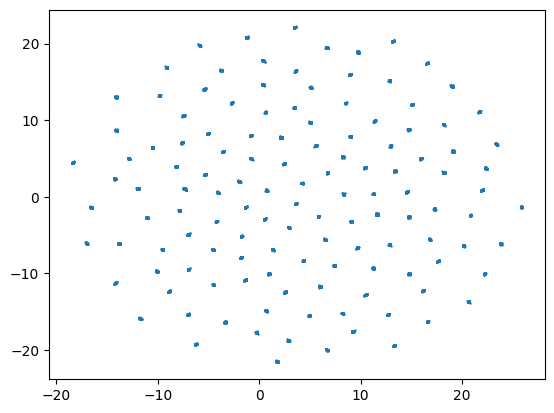

In [37]:
from umap import UMAP

umap = UMAP(n_components=2)
data_2d_umap = umap.fit_transform(torch.flatten(latents, start_dim=1).cpu())
# Create a figure and a 3D axes object
fig = plt.figure()
ax = fig.add_subplot(111)

# Create the initial scatter plot
ax.scatter(data_2d_umap[:, 0], data_2d_umap[:, 1], s=0.5)

# Show the plot
plt.show()

In [29]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [9]:
def calculate_wcss_umap(data_2d_umap):
    wcss = []
    for n in tqdm(range(2, 21)):  # change the range according to your needs
        kmeans = KMeans(n_clusters=n)
        data = torch.flatten(data_2d_umap, start_dim=1).cpu()
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)  # inertia_ is the WCSS for the model
    return wcss

# calculate WCSS for different numbers of clusters
wcss_umap = calculate_wcss_umap(latents)



  0%|                                                                                                                | 0/19 [00:10<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
tsne = TSNE(n_components=2)
# apply t-SNE to data
data_2d = tsne.fit_transform(torch.flatten(latents, start_dim=1).cpu())

In [ ]:
# Create a figure and a 3D axes object
fig = plt.figure()
ax = fig.add_subplot(111)

# Create the initial scatter plot
ax.scatter(data_2d[:, 0], data_2d[:, 1], s=0.5)

# Show the plot
plt.show()

### deciding the number of clusters

In [29]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\xinwei\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
  5%|████▏                                                                              | 1/20 [00:23<07:29, 23.66s/it]C:\Users\xinwei\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
 10%|████████▎                                                                          | 2/20 [02:24<24:15, 80.87s/it]C:\Users\xinwei\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarni

ValueError: x and y must have same first dimension, but have shapes (19,) and (20,)

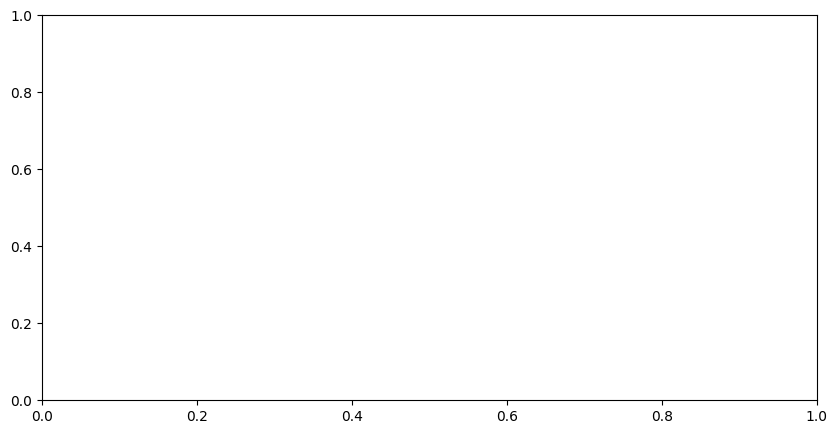

In [30]:
def calculate_wcss(latents):
    wcss = []
    for n in tqdm(range(2, 21)):  # change the range according to your needs
        kmeans = KMeans(n_clusters=n)
        data = torch.flatten(latents, start_dim=1).cpu()
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)  # inertia_ is the WCSS for the model
    return wcss



# calculate WCSS for different numbers of clusters
wcss = calculate_wcss(latents)



In [32]:
wcss

[986140.499339175,
 869505.0606631708,
 819694.0209426743,
 785642.1990883268,
 760934.4728065955,
 745724.7869051867,
 734105.2118314499,
 722259.5009777081,
 711904.7535994987,
 702508.9690809237,
 694584.8212776463,
 687067.6198292032,
 680649.9389668355,
 674773.3688534827,
 669926.692170877,
 665193.4642194572,
 661639.4121179607,
 658217.1916727715,
 654436.3704479537,
 651240.404522262]

In [34]:
# Convert list to DataFrame
wcss_df = pd.DataFrame(wcss)
wcss_df.to_csv('wcss.csv',index=False)
wcss_df

,0
0,986140.499339
1,869505.060663
2,819694.020943
3,785642.199088
4,760934.472807
5,745724.786905
6,734105.211831
7,722259.500978
8,711904.753599
9,702508.969081


In [39]:
def plot_elbow(wcss, filename=None):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(wcss) + 1), wcss, 'bo-')
    plt.title('The Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.grid()
    filename = 'elbow plot for k-means'
    plt.savefig(filename)

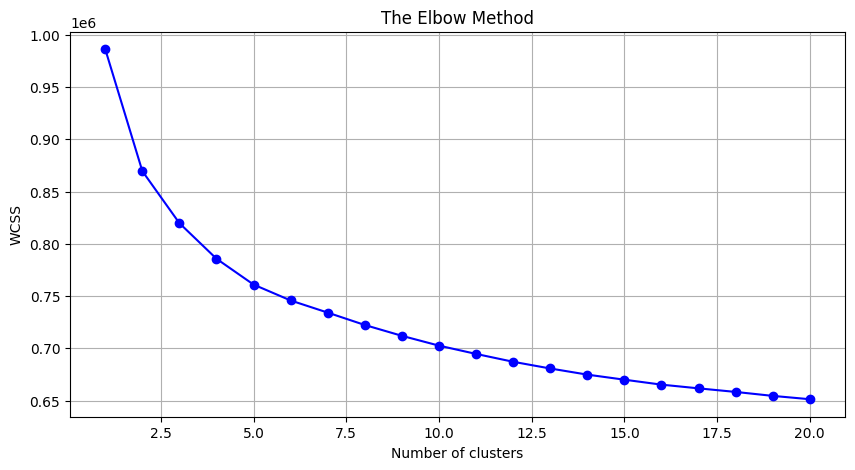

In [40]:
# plot the elbow graph
plot_elbow(wcss)

the number of clusters are set to 5, 10, 15

In [46]:
def calculate_slope(points):
    slopes = []
    for i in range(len(points) - 1):
        slope = (points[i + 1] - points[i]) / (i + 2 - i)
        slopes.append(slope)
    return slopes

def find_optimal_point(slopes, drop_threshold=0.1):
    optimal_point = 1
    for i in range(len(slopes)):
        if slopes[i] / slopes[i - 1] <= drop_threshold:
            optimal_point = i + 1
            break
    return optimal_point

In [48]:
# Calculate slopes
slopes = calculate_slope(wcss)
print(slopes)
# Find the optimal point based on the slope
optimal_point = find_optimal_point(slopes)

print("Optimal point:", optimal_point)

[-58317.71933800209, -24905.519860248256, -17025.91092717374, -12353.863140865637, -7604.842950704391, -5809.787536868418, -5922.8554268708685, -5177.373689104745, -4697.892259287473, -3962.0739016386797, -3758.6007242215564, -3208.8404311838676, -2938.2850566764246, -2423.3383413028205, -2366.6139757098863, -1777.0260507482453, -1711.110222594638, -1890.4106124088867, -1597.9829628458247]
Optimal point: 1


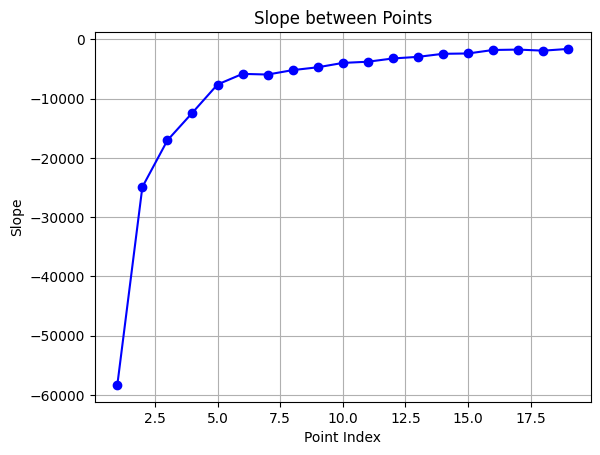

In [49]:
# Plot the slopes
plt.plot(range(1, len(wcss)), slopes, 'bo-')
plt.title('Slope between Points')
plt.xlabel('Point Index')
plt.ylabel('Slope')
plt.grid()
plt.show()

### HDBSCAN

In [8]:
# pip install --upgrade setuptools wheel
# pip install --upgrade cython
#  You can install the C/C++ extension by searching for 'c++' in the Extensions view (Ctrl+Shift+X).
# ERROR: Could not build wheels for hdbscan, which is required to install pyproject.toml-based projects

# First Make sure you've Microsoft Visual C++, check here

# Second install the hdbscan
# command: conda install -c conda-forge hdbscan

# Third install bertopic
# command: pip install bertopic

In [ ]:
import hdbscan
import numpy as np
import matplotlib.pyplot as plt

# Assuming `data` is your high-dimensional data
data = torch.flatten(latents, start_dim=1).cpu()
# Create an HDBSCAN instance
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)

# Fit the data
clusterer.fit(data)

# The labels_ property contains the cluster labels for each data point
# Noise points are assigned the label -1
labels = clusterer.labels_

# Let's plot the clusters
# For simplicity, let's assume data is 2D after dimensionality reduction (for instance, using UMAP)
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis')
plt.show()

In [ ]:
clusterer.labels_.to_csv()

In [ ]:
clusterer_labels_df = pd.DataFrame(clusterer.labels_)
clusterer_labels_df.to_csv('clusterer_labels.csv', index=False)

### Clustering

In [30]:
#Import required module
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import pandas as pd
import seaborn as sns

In [11]:
data_2d_umap[0]

array([ 6.391108 , -2.3148484], dtype=float32)

In [31]:
latents.shape

torch.Size([23040, 3, 112, 112])

In [32]:
n_clusters=5
# data_2d = data_2d_umap
data = latents

#Initialize the class object
kmeans = KMeans(n_clusters=n_clusters)

# data = torch.flatten(latents, start_dim=1).cpu()
# #predict the labels of clusters.
label = kmeans.fit_predict(data)

# get cluster centers
cluster_centers = kmeans.cluster_centers_
closest, _ = pairwise_distances_argmin_min(cluster_centers, data)
print(cluster_centers.shape, data.shape)

# Save closest points and cluster centers to CSV
df_center = pd.DataFrame({'Cluster Center': cluster_centers.tolist(), 'Closest Point Index': closest})
df_center.to_csv(f'../results/clustercenter/MARL_{n_clusters}cluster_centers.csv', index=False)

#Getting unique labels
plt.figure(figsize=(10, 8))
u_labels = np.unique(label)
num_labels = len(u_labels)
color_palette = sns.color_palette('husl', num_labels)

#plotting the results:
# plt.legend()

center_list = closest
print(center_list)

for i, each in enumerate(center_list):
    plt.scatter(data_2d[each][0],data_2d[each][1], s=20, c=[color_palette[i]])
    plt.annotate(each, (data_2d[each][0],data_2d[each][1]), ha="center", va="center", xytext=(0,10), textcoords='offset points')
for i in u_labels:
    plt.scatter(data_2d[label == i , 0] , data_2d[label == i , 1] , label = i, s=0.5, c=[color_palette[i]],alpha=0.5)
    
plt.axis('off')
plt.savefig(f'MARL_{n_clusters}_kmeans.png')
df = np.stack((label, floor.all_data_dirs)).transpose()
df = pd.DataFrame(df,columns=['label','data'])

for i in u_labels:
    df.loc[df['label']==str(i)].to_csv(f'../results/MARL_kmeans_{n_clusters}cluster{i}_{closest[i]}.csv',index=False)
    
# return kmeans, label
    


ValueError: Found array with dim 4. KMeans expected <= 2.

## Visualize the cluster center

umap: [8834, 1618, 6145, 2441, 21234]\
k-means: [3958, 7563, 8894, 16740, 3130]

In [2]:
k_means_center = [3958, 7563, 8894, 16740, 3130]

In [9]:
n_clusters=5
# data_2d = data_2d_umap
# data = data_2d_umap
cluster_count = n_clusters
file_path = f"../results/clustercenter/umap_{cluster_count}cluster_centers.csv"
indexes = pd.read_csv(file_path)['Closest Point Index'].tolist()
indexes

[8834, 1618, 6145, 2441, 21234]

In [10]:
def scale_crop(img): #B,C,H,W
    rescale = transforms.Compose([transforms.Resize(112),
                                  transforms.CenterCrop(56)])
    return rescale(img)

In [3]:
indexes = k_means_center

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


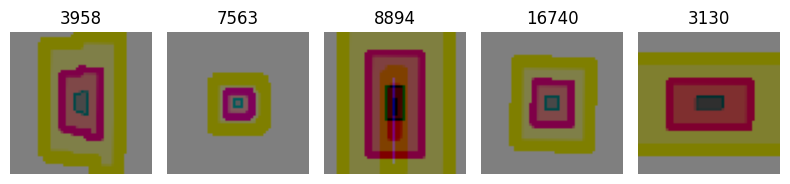

In [22]:
# Create a figure and axes with `cluster_count` subplots
fig, axes = plt.subplots(1, cluster_count, figsize=(8, 3))
image_size = 112
crop_size = 56

# Iterate over the `cluster_count` subplots
for i, index in enumerate(indexes):
    image_path = floor.all_data_dirs[index]
    # Read the image using torch's load
    image = torch.load(image_path)
    scaled = scale_crop(image)
    # Display the image in the corresponding subplot
    image_array = scaled.permute(1, 2, 0).numpy()  # Convert to (56, 56, 3) shape
    axes[i].imshow(image_array, cmap='gray')
    axes[i].set_title(f"{index}")
    axes[i].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Save the plot
plt.savefig(f"../results/recon_img/{cluster_count}cluster_sample.png")

[1389, 17469, 1881, 3464, 1310]

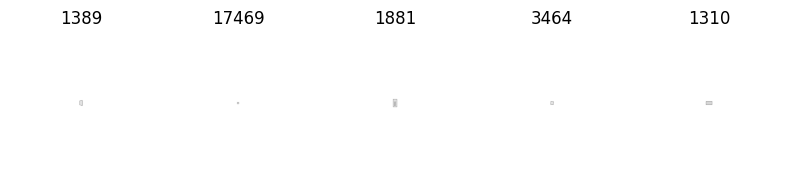

In [8]:
import os
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

cluster_count = 5
# Create a figure and axes with `cluster_count` subplots
fig, axes = plt.subplots(1, cluster_count, figsize=(8, 3))
image_size = 112
crop_size = 56

# Define the new directory
new_dir = 'kmeans_5_cluster'
num_indexes = []
# Create the new directory if it doesn't exist
if not os.path.exists(new_dir):
    os.makedirs(new_dir)

# Iterate over the `cluster_count` subplots
for i, index in enumerate(indexes):
    image_path = floor.all_data_dirs[index]
    # Split the path into the name and the extension
    file_name, file_extension = os.path.splitext(image_path)
    # Replace the '.pt' extension with '.png'
    png_file_path = file_name + '.png'
    # Read the image data
    img = mpimg.imread(png_file_path)
    # Display the image in the corresponding subplot
    axes[i].imshow(img, cmap='gray')
    # Extract numerical part from the file name
    num_index = int(os.path.basename(file_name))
    num_indexes.append(num_index)
    axes[i].set_title(f"{num_index}")
    axes[i].axis('off')

    # Move the file to the new directory
    shutil.copy(png_file_path, os.path.join(new_dir, os.path.basename(png_file_path)))

# Adjust the spacing between subplots
plt.tight_layout()

# Save the plot
plt.savefig(f"../results/recon_img/kmeans{cluster_count}cluster_sample.png")
num_indexes

In [9]:
indexes

[3958, 7563, 8894, 16740, 3130]

In [23]:
indexes = num_indexes
indexes

[1389, 17469, 1881, 3464, 1310]

In [24]:
file_path = r"..\data\data_root\geojson_0.json"

# Load the JSON data from the file
with open(file_path) as file:
    data = json.load(file)

# Extract features based on the OBJECTID in indexes list
desired_features = []
for feature in data['features']:
    if feature['properties']['OBJECTID'] in indexes:
        desired_features.append(feature)

# Extract information for footprint, Shape_Area_1, and height from desired features
extracted_info = []
for feature in desired_features:
    info['OBJECTID'] = OBJECTID
    OBJECTID = feature['properties']['OBJECTID']
    info = {
        'OBJECTID' : feature['properties']['OBJECTID'],
        'footprint': feature['properties']['footprint'],
        'Shape_Area_1': feature['properties']['Shape_Area_1'],
        'height': feature['properties']['HEIGHT']
    }
    extracted_info.append(info)

# Create a DataFrame from the extracted information
df = pd.DataFrame(extracted_info)
df

,OBJECTID,footprint,Shape_Area_1,height
0,1310,3059.0,4164.674553,31.51
1,1389,1914.0,4013.148863,22.13
2,1881,4174.0,5039.122150,25.11
3,3464,1282.0,6501.868900,21.97
4,17469,519.0,6028.433800,15.03


In [25]:
df.to_csv(f"../results/recon_img/kmeans{cluster_count}cluster_sample.csv",index=False)

In [13]:
floor.all_data_dirs[8834]

'../data/data_root/data00/18753.pt'

# Visualize and Save Reconstruction Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


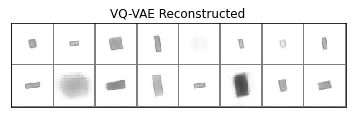

In [19]:
latent_centers = torch.from_numpy(kmeans.cluster_centers_.reshape(n_clusters, 64, 14, 14).astype('float32')).to(device)
vqae.eval()
valid_recon = vqae.decoder(latent_centers)
def show(img, title):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.set_title(title)
plt.figure()  # Create a new plot
show(torchvision.utils.make_grid(valid_recon.cpu().data) + 0.5, "VQ-VAE Reconstructed")
plt.savefig(f"{n_clusters}_VQrecon.png", bbox_inches='tight')

In [20]:
def rescale_img(img): #B,C,H,W
    rescale = transforms.Compose([transforms.Resize(112),
                                  transforms.Pad(56, fill=1.0)])
    return rescale(img)
rescaled_recon = rescale_img(valid_recon+0.5)

for i in range(rescaled_recon.shape[0]):
    save_image(rescaled_recon[i], f'../results/recon_img/{n_clusters}cluster-img{i}.jpg')
    
print('save to results/recon_img/*.jpg')

save to results/recon_img/*.jpg


### For rhino mapping-back 

In [22]:
import glob
import cv2
import os
import numpy as np
import torchvision.transforms.functional as TF
import imageio
import matplotlib.pyplot as plt

In [23]:
folder_path = "../results/recon_img/"  
img_files = []
for filename in os.listdir(folder_path):
    if "5cluster" in filename:
        print(filename)
        img_files.append(filename)

5cluster-img0.jpg
5cluster-img0_rectangle.jpg
5cluster-img1.jpg
5cluster-img1_rectangle.jpg
5cluster-img2.jpg
5cluster-img2_rectangle.jpg
5cluster-img3.jpg
5cluster-img3_rectangle.jpg
5cluster-img4.jpg
5cluster-img4_rectangle.jpg


In [24]:
def calc_height(image_path):
    print(image_path)
    fullpath = f"../results/recon_img/"+str(image_path)
    image = cv2.imread(fullpath)
    height, width, channels = image.shape
    print(height, width, channels)
    
    # Calculate the starting and ending indices for the central region
    start = (height - central_region_size) // 2
    end = start + central_region_size
    
    # Get the average pixel value in the central region for each channel
    central_region = image[start:end, start:end, :]
    average_pixel_value = np.mean(central_region, axis=(0,1))
    
    # Draw a red rectangle around the central region
    img_with_rectangle = np.copy(image)
    cv2.rectangle(img_with_rectangle, (start, start), (end, end), (0, 0, 255), 2)  # Draw red rectangle
    
    # Save the image with the red rectangle
    image_with_rectangle_path = fullpath.replace(".jpg", "_rectangle.jpg")  # Update the path as per your requirement
    imageio.imwrite(image_with_rectangle_path, img_with_rectangle)
    print(image_with_rectangle_path)
    return average_pixel_value

central_region_size = 10
height_info = []
for image_path in img_files:
    average_pixel_value = calc_height(image_path)
    height_info.append(average_pixel_value[0])

5cluster-img0.jpg
224 224 3
../results/recon_img/5cluster-img0_rectangle.jpg
5cluster-img0_rectangle.jpg
224 224 3
../results/recon_img/5cluster-img0_rectangle_rectangle.jpg
5cluster-img1.jpg
224 224 3
../results/recon_img/5cluster-img1_rectangle.jpg
5cluster-img1_rectangle.jpg
224 224 3
../results/recon_img/5cluster-img1_rectangle_rectangle.jpg
5cluster-img2.jpg
224 224 3
../results/recon_img/5cluster-img2_rectangle.jpg
5cluster-img2_rectangle.jpg
224 224 3
../results/recon_img/5cluster-img2_rectangle_rectangle.jpg
5cluster-img3.jpg
224 224 3
../results/recon_img/5cluster-img3_rectangle.jpg
5cluster-img3_rectangle.jpg
224 224 3
../results/recon_img/5cluster-img3_rectangle_rectangle.jpg
5cluster-img4.jpg
224 224 3
../results/recon_img/5cluster-img4_rectangle.jpg
5cluster-img4_rectangle.jpg
224 224 3
../results/recon_img/5cluster-img4_rectangle_rectangle.jpg


In [25]:
height_info

[170.12, 206.37, 176.69, 209.12, 132.11, 187.8, 177.97, 206.41, 213.68, 217.87]

In [26]:
# Loop through each image
image_paths = glob.glob('recon_img/*.png')
lower_thres = 0.3
higher_thres = 0.7
for image_path in image_paths:
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.convertScaleAbs(gray)
    edges = cv2.Canny(gray, lower_thres, higher_thres)  # Adjust the threshold values as needed

    # Save the edge image
    filename = os.path.splitext(os.path.basename(image_path))[0]  # Extract the filename without extension
    edge_image_path = f'edge_img/{filename}_edge.jpg'
    cv2.imwrite(edge_image_path, edges)

### get aggregated area

In [71]:
objectid_ref_df = pd.read_csv('objectid_ref.csv')

[1389, 17469, 1881, 3464, 1310]

In [72]:
def get_csv_df(index):
    desired_number = str(index)
    for filename in os.listdir(directory_path):
        if desired_number in filename:
            file_path = os.path.join(directory_path, filename)
            csv_df = pd.read_csv(file_path,index_col=None)
            csv_df['index'] = csv_df['data'].str.extract(r'(\d+)\.pt')
            csv_df['index']=csv_df['index'].astype(int)
    return csv_df

In [104]:
def calculate_aggregated_areas(csv_df):
    desired_features = []
    for feature in jsonfile['features']:
        if feature['properties']['OBJECTID'] in csv_df['index'].values:
            desired_features.append(feature)

    # Extract information for objectID, areas, and heights from desired features
    objectID_list = []
    footprint_list = []
    area_list = []
    height_list = []

    for feature in desired_features:
        objectID = feature['properties']['OBJECTID']
        footprint = feature['properties']['footprint']
        area = feature['properties']['Shape_Area_1']
        height = feature['properties']['HEIGHT']

        objectID_list.append(objectID)
        footprint_list.append(footprint)
        area_list.append(area)
        height_list.append(height)

        # Create a new DataFrame from the extracted information
        json_df = pd.DataFrame({
            'objectID': objectID_list,
            'footprint': footprint_list,
            'area': area_list,
            'height': height_list
        })
    merged_df = json_df.merge(csv_df, left_on='objectID', right_on='index')
    sum_of_area = merged_df['area'].sum()
    return sum_of_area, merged_df

In [125]:
def get_sum_of_area():
    merged_df = csv_df.merge(objectid_ref_df, left_on='index', right_on='OBJECTID')
    print(f"csv_df shape = {csv_df.shape}, objectid_ref_df = {objectid_ref_df.shape}")
    print(f"merged_df shape = {merged_df.shape}")
    sum_of_area = merged_df['building.area.m2'].sum()
    return sum_of_area

In [126]:
sum_of_area_list = []
json_file_path = r"..\data\data_root\geojson_0.json"
directory_path = r'../results/area_aggregation'  # Use r prefix for raw string
# Create an empty DataFrame to store the objectIDs
objectID_df = pd.DataFrame(columns=[0])
# Load the JSON data from the file
with open(json_file_path) as file:
    jsonfile = json.load(file)
    
for index in tqdm(num_indexes):
    csv_df = get_csv_df(index)
    # filtered_df = csv_df[csv_df['index'].isin(objectid_ref_df['OBJECTID'])]
    # print(filtered_df.shape)
    # sum_of_area, merged_df=calculate_aggregated_areas(filtered_df)
    sum_of_area = get_sum_of_area()
    sum_of_area_list.append(sum_of_area)
    # merged_df.to_csv(f'../results/area_aggregation/5cluster_{index}_merged.csv',index=False)
    # objectID_df = pd.concat([objectID_df, merged_df['objectID']], ignore_index=True)
# objectID_df.to_csv('../results/area_aggregation/objectID.csv', index=False)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.52it/s]

csv_df shape = (4259, 7), objectid_ref_df = (13367, 5)
merged_df shape = (4259, 12)
csv_df shape = (2730, 7), objectid_ref_df = (13367, 5)
merged_df shape = (2730, 12)
csv_df shape = (852, 7), objectid_ref_df = (13367, 5)
merged_df shape = (852, 12)
csv_df shape = (4423, 7), objectid_ref_df = (13367, 5)
merged_df shape = (4423, 12)
csv_df shape = (1105, 7), objectid_ref_df = (13367, 5)
merged_df shape = (1105, 12)


In [129]:
sum_of_area_list

[1141716.3815,
 728261.4942000001,
 243567.91410000002,
 1193941.6029,
 291030.5241]

In [113]:
objectid_ref_df

,Unnamed: 0,OBJECTID,idf.kw,FootprintArea.m2,building.area.m2
0,11,37,SingleFamily-pre-1980,91.316398,69.3963
1,14,46,SingleFamily-2004,99.909763,193.0462
2,20,52,MultiFamily-pre-1980,94.014890,189.7018
3,24,57,SingleFamily-pre-1980,341.028058,314.1878
4,28,63,SingleFamily-2004,268.205501,325.5216
...,...,...,...,...,...
13362,15476,25638,SingleFamily-pre-1980,227.679816,121.2345
13363,15477,25642,MultiFamily-pre-1980,62.026620,262.0709
13364,15478,25643,MultiFamily-2004,129.942767,464.5000
13365,15479,25644,SingleFamily-pre-1980,164.018356,176.6958


In [114]:
objectid_ref_df.sum()

Unnamed: 0                                                  107901183
OBJECTID                                                    187510622
idf.kw              SingleFamily-pre-1980SingleFamily-2004MultiFam...
FootprintArea.m2                                       3274820.381714
building.area.m2                                          3597987.272
dtype: object

In [130]:
sum_of_area_list

[1141716.3815,
 728261.4942000001,
 243567.91410000002,
 1193941.6029,
 291030.5241]

In [132]:
new_df = pd.DataFrame({'index': num_indexes, 'area': sum_of_area_list})
new_df.to_csv('area_aggregation_kmeans_5.csv')

In [101]:
objectID_df

,0
0,349
1,604
2,620
3,695
4,700
...,...
13364,25552
13365,25595
13366,25619
13367,25621


In [80]:
objectID_df.transpose()

,0,1,2,3,4
objectID,NaN,NaN,NaN,NaN,NaN
0,167.0,40.0,453.0,37.0,46.0
1,172.0,43.0,467.0,57.0,59.0
2,233.0,52.0,518.0,58.0,74.0
3,234.0,65.0,533.0,63.0,77.0
...,...,...,...,...,...
7738,NaN,NaN,NaN,25608.0,NaN
7739,NaN,NaN,NaN,25624.0,NaN
7740,NaN,NaN,NaN,25632.0,NaN
7741,NaN,NaN,NaN,25634.0,NaN


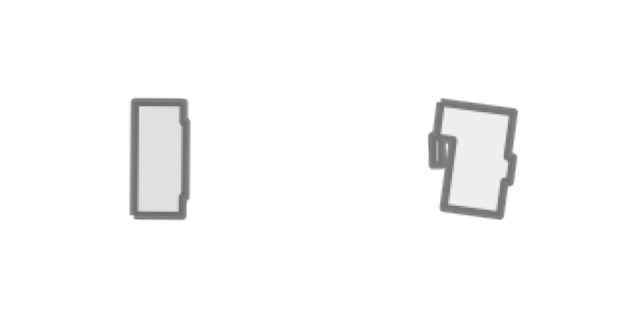

In [61]:
index1 = 167
index2 = 25645
image1_path = f'../data/data_root/data00/{index1}.png'
image1 = mpimg.imread(image1_path)
image2_path = f'../data/data_root/data00/{index2}.png'
image2 = mpimg.imread(image2_path)
# Get the center coordinates
height, width, _ = image1.shape
center_x = width // 2
center_y = height // 2

# Calculate the coordinates for the center 150x150 pixels
x1 = center_x - 75
x2 = center_x + 75
y1 = center_y - 75
y2 = center_y + 75

# Extract the center 150x150 pixels from each image
center1 = image1[y1:y2, x1:x2]
center2 = image2[y1:y2, x1:x2]
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2)

# Plot the first image in the left subplot
ax1.imshow(center1)
ax1.axis('off')

# Plot the second image in the right subplot
ax2.imshow(center2)
ax2.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()